# Project 4

## Neural Networks

Attempts to harness the power of neural networks to explore whether any additional accuracy could be obtained from these features.

Two models were fit and run, both on sampled data to even out class imbalances. The samplers for this purpose were the `RandomUnderSampler` and `RandomOverSampler` classes from the [imbalanced-learn](https://imbalanced-learn.org/stable/) third-party package.

As will be demonstrated, the accuracy is not significantly better than any other attempted model.

### 0. Imports and Preliminaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input

np.random.seed(0)
import json

2022-09-22 14:07:48.792626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# plot image preliminaries

IMGDIR = '../images/'
with open('./styles.json', 'r') as f:
    PLOT_STYLES = json.loads(f.read())
    
PLOT_STYLES.keys()

dict_keys(['title', 'axis-label', 'tick-label'])

In [3]:
# Import data
full_df = pd.read_csv('../data/ohe_data.csv')

full_df.drop(columns=['Start_Time', 'Start_Lat', 'Start_Lng', 'day'], inplace=True)

# drop "Unnamed: 0" column if exists
if "Unnamed: 0" in full_df.columns: full_df.drop(columns=['Unnamed: 0'], inplace=True)

# correct sunrise/sunset column to be numerical if not, 0=Day, 1=Night
full_df = full_df.replace({'Day': 0, 'Night': 1})

# make any true/false values into 1/0
full_df = full_df.replace({True: 1, False: 0})

In [4]:
# set up modeling dataframe (done for testing purposes - full_df can quickly be sampled down)
model_df = full_df
model_df.shape, model_df['Severity'].value_counts(normalize=True)

((2731050, 129),
 0    0.900065
 1    0.099935
 Name: Severity, dtype: float64)

---

### 1. Neural Network 1

#### 1a. Testing Network

Run and plot metrics on a long-running network to try and isolate best parameters.

This model is being fit on undersampled data to even out category imbalances. Undersampling is performed by the `RandomUnderSampler` class from the [imbalanced-learn](https://imbalanced-learn.org/stable/) third-party package.

#### Model Fitting

Fit a test model and then narrow down closer to a production model by optimizing epochs and other hyperparameters

In [5]:
# create X and y
X = model_df.drop('Severity', axis=1)
y = model_df['Severity']

# resample to even out categories via undersampling majority class
rus = RandomUnderSampler(random_state=1)
X_rs, y_rs = rus.fit_resample(X, y)
print(X_rs.shape, y_rs.shape)
print(y_rs.value_counts(normalize=True))

# scale X data
mms = MinMaxScaler()
X_mms = mms.fit_transform(X_rs)

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X_mms, y_rs,
                                                    stratify=y_rs,
                                                    random_state=1)

(545856, 128) (545856,)
0    0.5
1    0.5
Name: Severity, dtype: float64


In [6]:
# set up network architecture
nn = Sequential()
nn.add(Dense(32, 'relu'))
nn.add(Dense(1, 'sigmoid'))

# compile model
nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

In [7]:
%%time

# fit test network on 20 epochs
nnh = nn.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
3199/3199 [==============================] - 5s 1ms/step - loss: 0.3967 - accuracy: 0.8320 - precision: 0.8230 - recall: 0.8460 - val_loss: 0.3737 - val_accuracy: 0.8432 - val_precision: 0.8294 - val_recall: 0.8641
Epoch 2/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3668 - accuracy: 0.8455 - precision: 0.8328 - recall: 0.8647 - val_loss: 0.3671 - val_accuracy: 0.8455 - val_precision: 0.8271 - val_recall: 0.8736
Epoch 3/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3617 - accuracy: 0.8482 - precision: 0.8353 - recall: 0.8674 - val_loss: 0.3637 - val_accuracy: 0.8470 - val_precision: 0.8356 - val_recall: 0.8640
Epoch 4/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3590 - accuracy: 0.8493 - precision: 0.8371 - recall: 0.8674 - val_loss: 0.3624 - val_accuracy: 0.8471 - val_precision: 0.8264 - val_recall: 0.8786
Epoch 5/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3571 - accuracy: 0

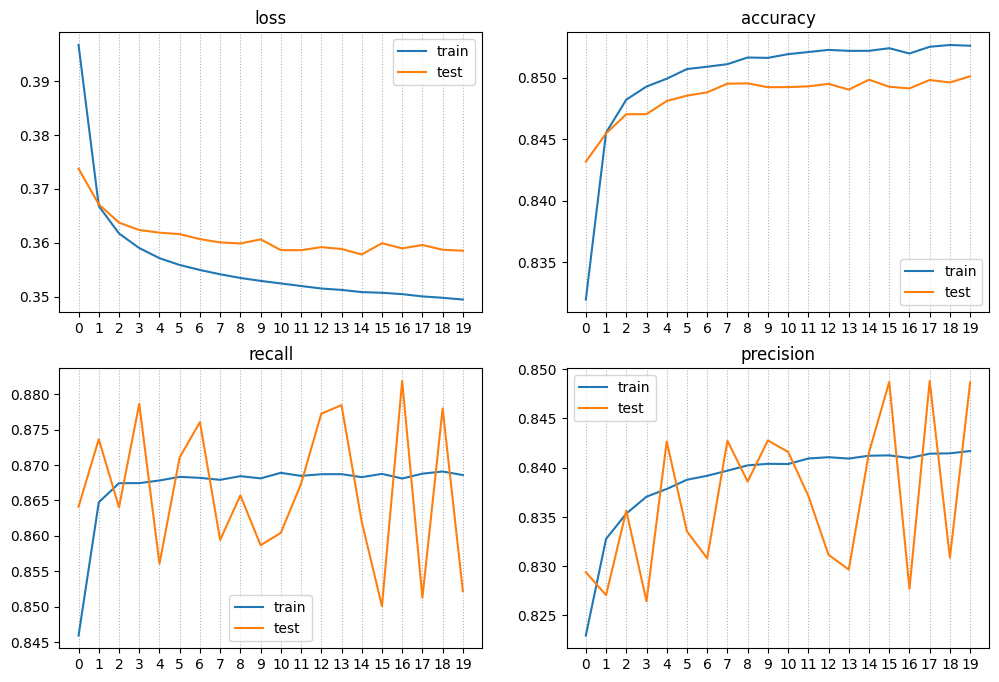

In [8]:
# plot metrics for test and train data

fig, ax = plt.subplots(2,2,figsize=(12,8))

metrics = ['loss', 'accuracy', 'recall', 'precision']
ix = 0

for i in (0,1):
    for j in (0,1):
        m = metrics[ix]
        ax[i][j].plot(nnh.history[m], label='train')
        ax[i][j].plot(nnh.history['val_' + m], label='test')
        #ax.set_ylim(0.2, 0.3)
        ax[i][j].set_xticks(list(range(0,20)))
        ax[i][j].grid(True, axis='x', ls=':')
        ax[i][j].set_title(m)
        ax[i][j].legend()
        ix += 1

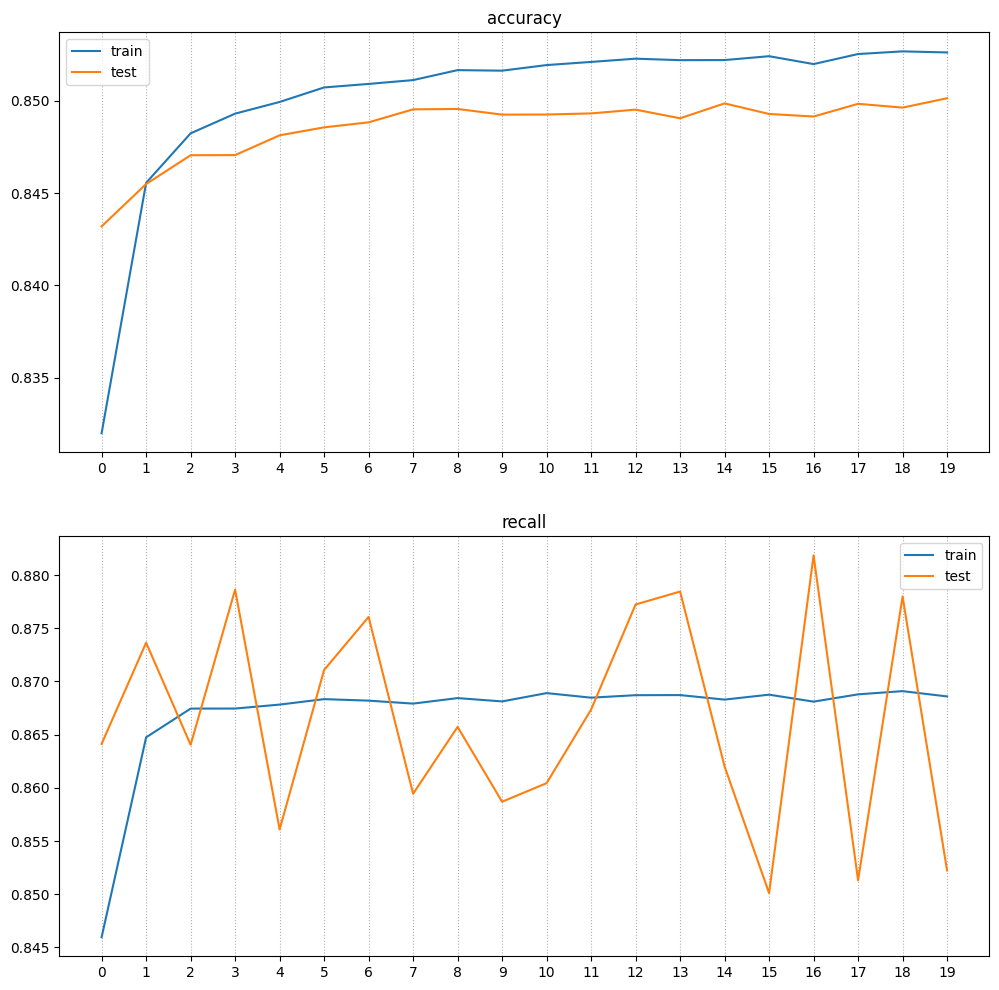

In [9]:
# nicer plots for just the metrics we care about - accuracy and recall
# plot metrics for test and train data

fig, ax = plt.subplots(2,1,figsize=(12,12))

metrics = ['accuracy', 'recall']
ix = 0

for j in (0,1):
    m = metrics[ix]
    ax[j].plot(nnh.history[m], label='train')
    ax[j].plot(nnh.history['val_' + m], label='test')
    #ax.set_ylim(0.2, 0.3)
    ax[j].set_xticks(list(range(0,20)))
    ax[j].grid(True, axis='x', ls=':')
    ax[j].set_title(m)
    ax[j].legend()
    ix += 1

**Plot Interpretations:** Accuracy is generally rising but recall is inconsestent ( thought within the same 0.83 to 0.88 range. There is some element to randomness in these models but for this purpose I'll just select the epoch with highest recall and do production model on that.

In [10]:
# show epoch with best recall, since we're trying to optimize for recall
np.argmax(nnh.history['val_recall'])

16

In [11]:
# If we are aiming for best recall, then let's find it and 
# use that number of epochs on this run (accuracy is pretty stable so
# I'm not worrying about there being any serious accuracy issues when
# choosing based on recall)

epochs = np.argmax(nnh.history['val_recall']) + 1

# set up architecture, compile, and fit nn model using num epochs from above
nn2 = Sequential()
nn2.add(Dense(32, 'relu'))
nn2.add(Dense(1, 'sigmoid'))

nn2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

nnh2 = nn2.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/17
3199/3199 [==============================] - 8s 2ms/step - loss: 0.4008 - accuracy: 0.8292 - precision: 0.8203 - recall: 0.8430 - val_loss: 0.3750 - val_accuracy: 0.8415 - val_precision: 0.8300 - val_recall: 0.8588
Epoch 2/17
3199/3199 [==============================] - 6s 2ms/step - loss: 0.3673 - accuracy: 0.8457 - precision: 0.8333 - recall: 0.8643 - val_loss: 0.3666 - val_accuracy: 0.8465 - val_precision: 0.8337 - val_recall: 0.8656
Epoch 3/17
3199/3199 [==============================] - 7s 2ms/step - loss: 0.3614 - accuracy: 0.8483 - precision: 0.8358 - recall: 0.8668 - val_loss: 0.3640 - val_accuracy: 0.8472 - val_precision: 0.8373 - val_recall: 0.8619
Epoch 4/17
3199/3199 [==============================] - 6s 2ms/step - loss: 0.3584 - accuracy: 0.8495 - precision: 0.8374 - recall: 0.8674 - val_loss: 0.3616 - val_accuracy: 0.8487 - val_precision: 0.8361 - val_recall: 0.8673
Epoch 5/17
3199/3199 [==============================] - 7s 2ms/step - loss: 0.3565 - accuracy: 0

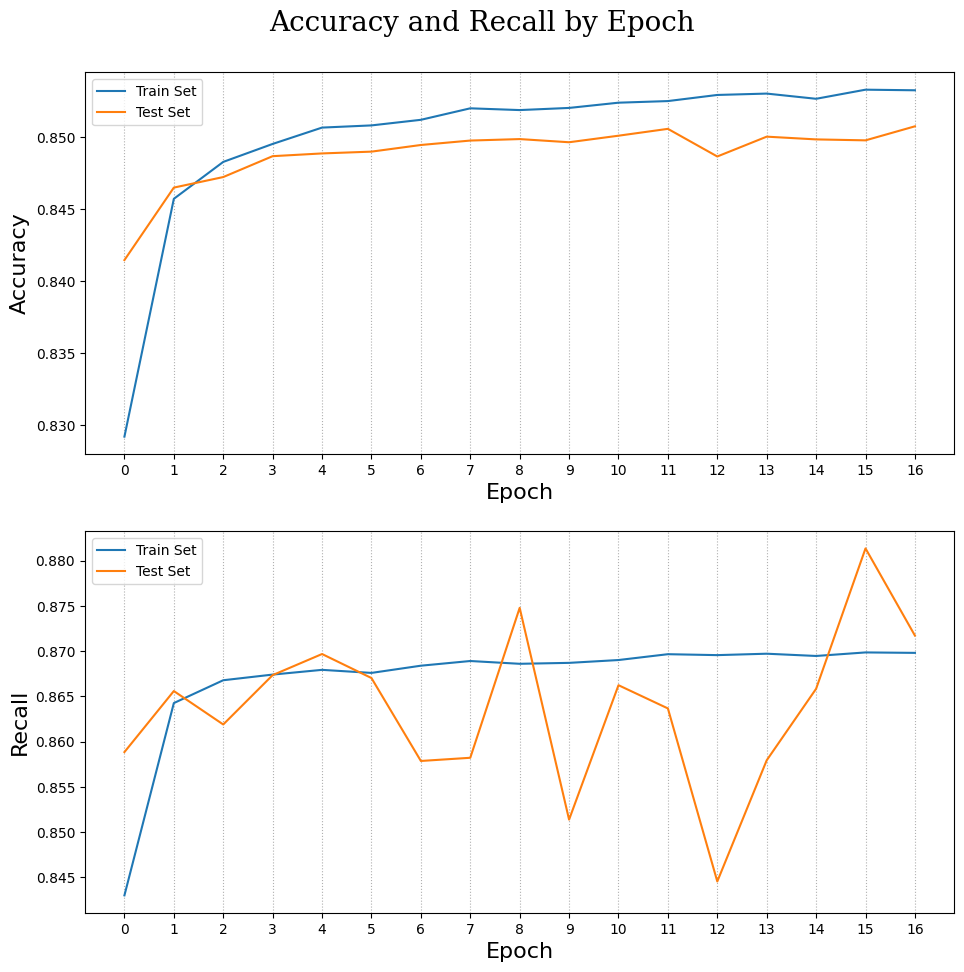

In [12]:
# plot metrics for test and train data

# This will be 2 plots
fig, ax = plt.subplots(2,1,figsize=(10,10))

metrics = ['accuracy', 'recall']
ix = 0

for j in (0,1):
    m = metrics[ix]
    ax[j].plot(nnh2.history[m], label='Train Set')
    ax[j].plot(nnh2.history['val_' + m], label='Test Set')
    #ax.set_ylim(0.2, 0.3)
    ax[j].set_xticks(list(range(0,epochs)))
    ax[j].grid(True, axis='x', ls=':')
    #ax[j].set_title(m.title(), size=18)
    ax[j].set_xlabel("Epoch", fontdict=PLOT_STYLES['axis-label'])
    ax[j].set_ylabel(m.title(), fontdict=PLOT_STYLES['axis-label'])
    ax[j].legend()
    ix += 1

plt.suptitle("Accuracy and Recall by Epoch", fontdict=PLOT_STYLES['title'], size=20)
plt.tight_layout(pad=2)    
plt.savefig(IMGDIR + 'nn_accuracy-and-recall.png')

**Plot Interpretation:** As described above when interpreting previous plots, due to an element of randomness the recall does not match when refitting. However, generally it is within the same range so that should be good for our purposes here of using neural networks as sort of a "support" model.

#### Model Evaluation

Review metrics and run cross-validation to test accuracy.

In [13]:
test_preds = nn2.predict(X_test)

4265/4265 [==============================] - 3s 634us/step


In [14]:
# show confusion matrix
cm = confusion_matrix(y_test, (test_preds >= 0.5).astype(int), normalize='true')
cm

array([[0.82977195, 0.17022805],
       [0.12828292, 0.87171708]])

In [15]:
# get cm metrics
tn, fp, fn, tp = cm.flatten()
tn, fp, fn, tp

(0.8297719545081487,
 0.17022804549185133,
 0.12828291710634307,
 0.8717170828936569)

In [16]:
# get recall
recall = tp / (tp + fn)
recall

0.8717170828936569

**NOTE** A recall of 0.86 is quite good and mostly in line with other models.

In [17]:
# try model on a few random samples (low-budget cross-val)
n_tries = 5

scores = []

for i in range(n_tries):
    sample = model_df.sample(250_000)
    sample_y = sample['Severity']
    sample_X = sample.drop('Severity', axis=1)
    mms = MinMaxScaler()
    sXmms = mms.fit_transform(sample_X)
    preds = (nn2.predict(sXmms) >= 0.5).astype(int)
    cm = confusion_matrix(sample_y, preds)
    tn, fp, fn, tp = cm.flatten()
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    scores.append((accuracy, recall))
    print(i)
    print(sample_y.value_counts(normalize=True))
    print(f'recall: {recall}; acc.: {accuracy}')
    print(classification_report(sample_y, preds))

7813/7813 [==============================] - 5s 635us/step
0
0    0.900436
1    0.099564
Name: Severity, dtype: float64
recall: 0.9139447993250572; acc.: 0.781596
              precision    recall  f1-score   support

           0       0.99      0.77      0.86    225109
           1       0.30      0.91      0.45     24891

    accuracy                           0.78    250000
   macro avg       0.65      0.84      0.66    250000
weighted avg       0.92      0.78      0.82    250000

7813/7813 [==============================] - 5s 629us/step
1
0    0.899608
1    0.100392
Name: Severity, dtype: float64
recall: 0.9056896963901506; acc.: 0.79666
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    224902
           1       0.32      0.91      0.47     25098

    accuracy                           0.80    250000
   macro avg       0.65      0.85      0.67    250000
weighted avg       0.92      0.80      0.83    250000

7813/7813 [==========

In [18]:
accs, recalls = zip(*scores)
avg_acc = np.mean(accs)
avg_recall = np.mean(recalls)
print(f'Mean accuracy: {avg_acc}\nMean recall: {avg_recall}')

Mean accuracy: 0.8020576
Mean recall: 0.8999596192123723


#### Conclusion

The final tests were run on a sample subset of the original with the same target imbalance. Though the model was fit on a more balanced subset of data, it translated fine to a more imbalanced set. With an accuracy of above 80% and recall approaching 90%, this model provides a reasonably high true positive rate and confirms our other models.

---

### 2. Neural Network 2

This second network was a more complex attempt which, after fitting, was saved to disk. It is loaded here, reviewed for architecture, and used in a simple cross-validation to test its performance.

#### Model Fitting
The model was fit to the data oversampled using [imbalanced-learn](https://imbalanced-learn.org/stable/)'s `RandomOverSampling` class:

```python
oversample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_over, y_over = oversample.fit_resample(X, y)
```

This resulted in a lower target imbalance:
```
0    0.666667
1    0.333333
Name: Severity, dtype: float64
```

The data was then split into train and test sets, with the X values of both train and test standard scaled:
```python
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
```

The model was finally built and fit via the following code:
```python
model = Sequential()

# input layer w/128 nodes
model.add(Input(shape=X.shape[1]))

# hidden w/ 100 nodes
model.add(Dense(100, activation='relu'))

# hidden w/ 50 nodes
model.add(Dense(50, activation='relu'))

# hidden w/ 10 nodes
model.add(Dense(10, activation='relu'))
# output
model.add(Dense(1, activation='sigmoid'))

# Compile it
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'], )

#Fit it
history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        verbose=1, 
        epochs=10
)
```

In [19]:
# Gabe's neural network
saved_model = load_model('../models/model1')

In [20]:
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               12900     
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 18,471
Trainable params: 18,471
Non-trainable params: 0
_________________________________________________________________


#### Model Metrics

The above model was fit on the same dataset being used here but on standard scaled data (not minmaxscaled), hence the adjustment to standard scaling below.

In [21]:
# get metrics

sample = model_df.sample(1_000_000)
sample_y = sample['Severity']
sample_X = sample.drop('Severity', axis=1)
mms = StandardScaler()
sXmms = mms.fit_transform(sample_X)
print(classification_report(sample_y, (saved_model.predict(sXmms) >= 0.5).astype(int)))

31250/31250 [==============================] - 22s 717us/step
              precision    recall  f1-score   support

           0       0.98      0.87      0.92    900363
           1       0.41      0.83      0.55     99637

    accuracy                           0.86   1000000
   macro avg       0.69      0.85      0.73   1000000
weighted avg       0.92      0.86      0.88   1000000



#### Conclusion

The saved model provides similar results which support results from other models.

---

### 3. Conclusion

Neural Network supports logistic regression results, with perhaps slightly better accuracy. Recall is pretty decent over the tests, which is what we are looking for. Due to their lack of interpretability, however, they are much less relevant to the current problem statement. The fact that we have been unable to extract additional accuracy from this data would suggest that the other models have fully captured what this data can show.